In [8]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils

from sklearn.neighbors import KernelDensity
from utils import total_variation_distance

%matplotlib inline

The difficulties with this sampling was with:
1) The bandwith factor. For high number of samples (>1000), a good bandwith in the bivariate case seems to be ~.2 to ~.3. I can't draw a proper conclusion without plotting the pdf curve relative to the sample points, but oversmoothing was certainly an issue. The estimated curve did not change from the standard normal as much as it should have.

2) Type casting. Numpy assumes np.int unless given evidence otherwise. Assuming that an array should be a float array will cause rounding issues

# Gibbs Sampling #

(From wikipedia) Gibbs sampling, in its basic incarnation, is a special case of the Metropolis–Hastings algorithm.  The point of Gibbs sampling is that given a multivariate distribution it is simpler to sample from a conditional distribution than to marginalize by integrating over a joint distribution.  Suppose we want to obtain $k$ samples of $\mathbf{X} = (x_1, \dots, x_n)$ from a joint distribution $p(x_1, \dots, x_n)$.  Denote the $i$th sample by $\mathbf{X}^{(i)} = \left(x_1^{(i)}, \dots, x_n^{(i)}\right)$.  We proceed as follows:

1. We begin with some initial value $\mathbf{X}^{(i)}$.
2. We want the next sample. Call this next sample $\mathbf{X}^{(i+1)}$. Since $\mathbf{X}^{(i+1)} = \left(x_1^{(i+1)}, x_2^{(i+1)}, \dots, x_n^{(i+1)}\right)$ is a vector, we sample each component of the vector, $x_j^{(i+1)}$, from the distribution of that component conditioned on all other components sampled so far. But there is a catch: we condition on $\mathbf{X}^{(i+1)}$'s components ''up to'' $x_{j-1}^{(i+1)}$, and thereafter condition on $\mathbf{X}^{(i)}$'s components, starting from $x_{j+1}^{(i)}$ to $x_n^{(i)}$. To achieve this, we sample the components in order, starting from the first component. More formally, to sample $x_j^{(i+1)}$, we update it according to the distribution specified by $p\left(x_j^{(i+1)}|x_1^{(i+1)},\dots,x_{j-1}^{(i+1)},x_{j+1}^{(i)},\dots,x_n^{(i)}\right)$. We use the value that the $(j+1)$th component had in the $i$th sample, not the $(i+1)$th sample.
3. Repeat the above step $k$ times.

If such sampling is performed, these important facts hold:
* The samples approximate the joint distribution of all variables.
* The marginal distribution of any subset of variables can be approximated by simply considering the samples for that subset of variables, ignoring the rest.
* The expected value of any variable can be approximated by averaging over all the samples.

In [9]:
def gibbs_sampling(init_func, conditional_dists, num_iters, step=1):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    conditional_dists -- list of the conditional densities
        functions for x_i given all other RVs
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    result = np.array([init_func()])
    dim = len(result[0])
    for x in range(num_iters):
        proposed = np.copy(result[-1])
        for i in range(dim):
            proposed[i] = conditional_dists[i](proposed)
        result = np.append(result, [proposed], axis=0)
    return np.array(result[::step])

## Multivariate Gaussians ##

In [10]:
def bivariate_gaussian_conditionals(mu, cov):
    """
    Returns the conditional distributions
    of x1|x2 and x2|x1 as functions.

    mu -- mean vector
    cov -- covariance matrix
    """
    p = cov[0][1] / np.sqrt(cov[0][0] * cov[1][1])
    std_dev = [np.sqrt((1 - p**2) * cov[0][0]), np.sqrt((1 - p**2) * cov[1][1])]
    l = [np.sqrt(cov[0][0]/cov[1][1]), np.sqrt(cov[1][1]/cov[0][0])]
    def p1(x):
        return stats.norm.rvs(loc=mu[0] + p * l[0] * (x[1] - mu[1]), scale=std_dev[0], size=1)
    def p2(x):
        return stats.norm.rvs(loc=mu[1] + p * l[1] * (x[0] - mu[0]), scale=std_dev[1], size=1)
    return [p1, p2]

### 2D Uncorrelated Gaussian ###

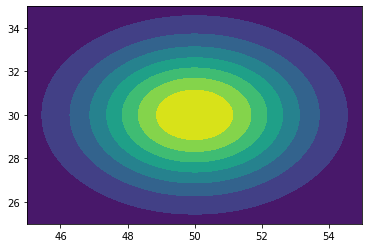

In [11]:
mu = np.array([50., 30.], np.float64)
cov = np.array([[5, 0], [0, 5]], np.float64)

X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))

gauss = stats.multivariate_normal(mu, cov).pdf(pos)
plt.contourf(X, Y, gauss)
plt.show()

100 0.46338976554263334
200 0.41317495686951844
300 0.3862829897255247
400 0.3682498720042897
500 0.3548354859253629
600 0.3442343894027812
700 0.3355163307697966
800 0.32814156672479844
900 0.32177023535581634
1000 0.3161750921113479
2000 0.28170344098722605
3000 0.2633029151613469
4000 0.2509796878205038
5000 0.24181905754858166
6000 0.23458274406811255
7000 0.22863356440144758
8000 0.22360213961467565
9000 0.2192560267216619


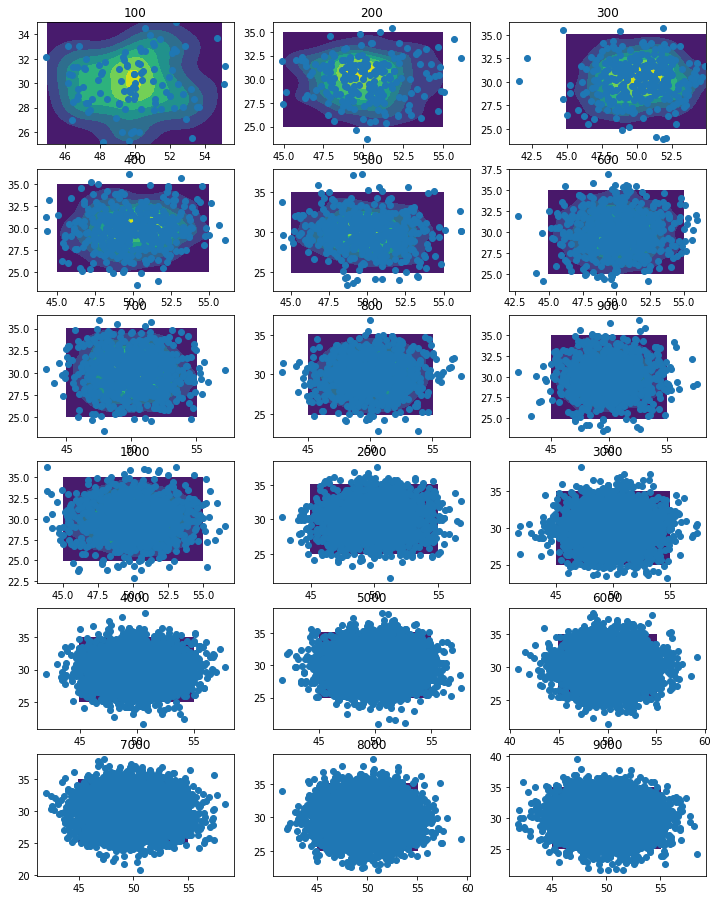

In [12]:
marginals = bivariate_gaussian_conditionals(mu, cov)
init_func = lambda: mu
tvd = np.array([], np.float64)
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = gibbs_sampling(init_func, marginals, i)

#     kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(samples)
#     estimate = np.exp(np.array([kde.score_samples(x) for x in pos]))
    kde = stats.gaussian_kde(samples.T)
    print(i, kde.factor)
    estimate = np.array([kde.evaluate(x) for y in pos for x in y])
    estimate = np.reshape(estimate, (129,129))

    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))

    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

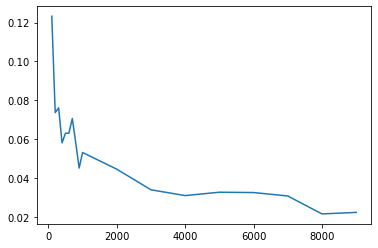

In [13]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

### 2D Correlated Jointly Gaussian ###

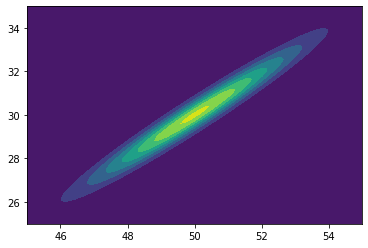

In [14]:
mu = np.array([50, 30], np.float64)
cov = np.array([[4, 3.9], [3.9, 4]], np.float64)

gauss = stats.multivariate_normal(mu, cov).pdf(pos)
plt.contourf(X, Y, gauss)
plt.show()

100 0.46338976554263334
200 0.41317495686951844
300 0.3862829897255247
400 0.3682498720042897
500 0.3548354859253629
600 0.3442343894027812
700 0.3355163307697966
800 0.32814156672479844
900 0.32177023535581634
1000 0.3161750921113479
2000 0.28170344098722605
3000 0.2633029151613469
4000 0.2509796878205038
5000 0.24181905754858166
6000 0.23458274406811255
7000 0.22863356440144758
8000 0.22360213961467565
9000 0.2192560267216619


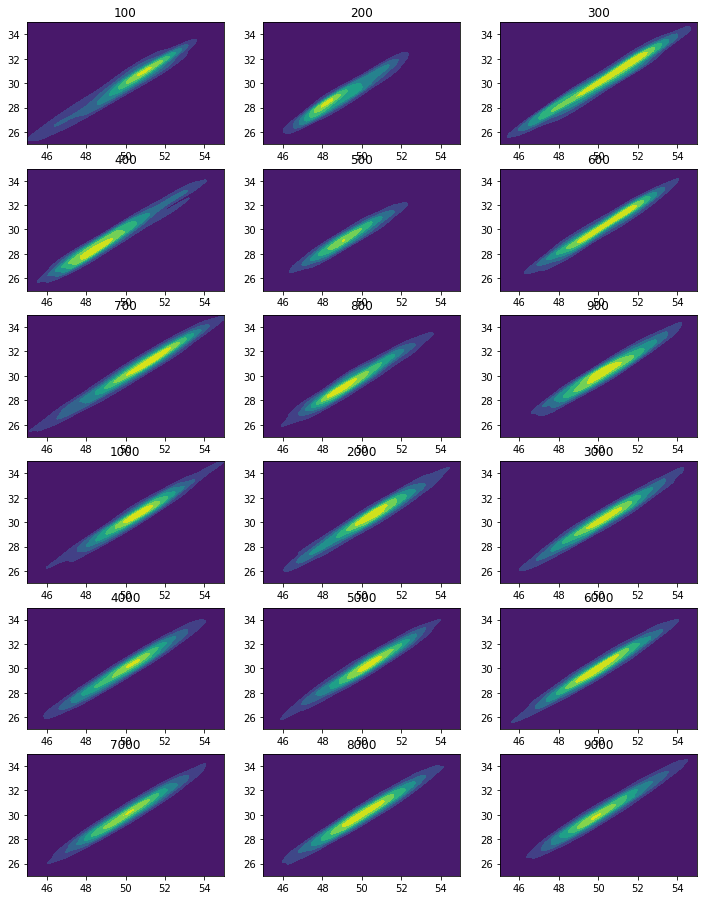

In [15]:
marginals = bivariate_gaussian_conditionals(mu, cov)
init_func = lambda: mu
tvd = np.array([], np.float64)
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = gibbs_sampling(init_func, marginals, i)

    kde = stats.gaussian_kde(samples.T)
    print(i, kde.factor)
    estimate = np.array([kde.evaluate(x) for y in pos for x in y])
    estimate = np.reshape(estimate, (129,129))

    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))
    
    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

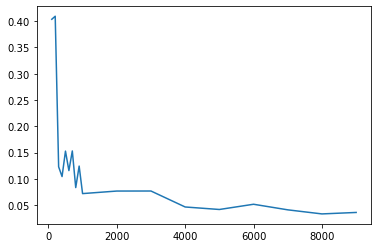

In [9]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

### Error & Correlation ###

In [ ]:
X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))
mu = np.array([50, 30], np.float64)

tvd = np.array([])
init_func = lambda: mu
for i in np.arange(-0.9, 1, 0.1):
    cov = np.array([[4, 4*i], [4*i, 4]])

    marginals = bivariate_gaussian_marginals(mu, cov)
    gauss = stats.multivariate_normal(mu, cov).pdf(pos)

    samples = gibbs_sampling_marginal(init_func, marginals, 15000)
    kde = KernelDensity(kernel='gaussian', bandwidth=1.3).fit(samples)
    estimate = np.exp(np.array([kde.score_samples(x) for x in pos]))
    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))

In [ ]:
plt.stem(np.arange(-0.9, 1, 0.1), tvd)
plt.show()